# 이미지 분석
>complete
- toc: false
- badges: true
- comments: true
- categories: [Big Data Analysis]
- image: images/chart-preview.png

## Fastai를 이용한 강아지와 고양이 분류 모델 사용해보기

`-` 데이터 다운로드 및 전처리

In [2]:
from fastai.vision.all import *

In [3]:
path=untar_data(URLs.PETS)/'images'

In [4]:
path

Path('C:/Users/Moon/.fastai/data/oxford-iiit-pet/images')

In [5]:
files = get_image_files(path)

In [6]:
files[2]

Path('C:/Users/Moon/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.jpg')

- 고양이와 강아지 이미지는 파일명의 첫 글자가 각각 대문자, 소문자로 저장되어 있다.
- 파일명의 대소문자 구분을 통해 cat, dog를 구별해주는 함수를 구현한다.

In [7]:
def label_func(f):
    if f[0].isupper():
        return 'cat'
    else:
        return 'dog'

In [8]:
label_func('asdf')

'dog'

- 여기서 사용하는 데이터는 파일명을 통해 종속변수를 분류해놨기 때문에 from_name_func를 사용하여 ImageDataLoaders 오브젝트로 만들어준다.
- 인자로는 이미지가 위치한 경로와 파일명들, 위에 구현했던 함수, 이미지의 크기를 변환해주는 Resize함수를 사용한다.

In [9]:
dls=ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224))

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


`-` ImageDataLoaders 오브젝트의 기능

- show_batch()를 사용한 이미지 preview

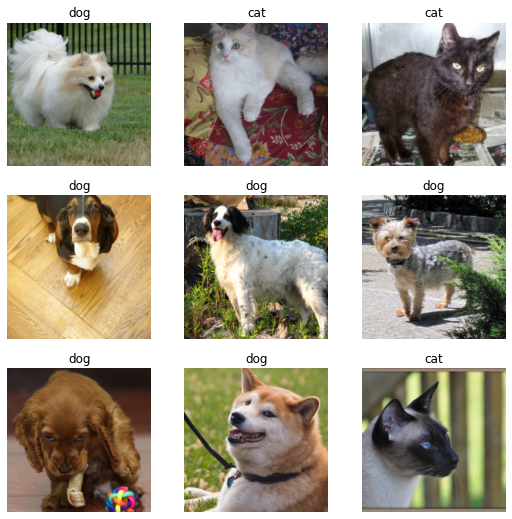

In [10]:
dls.show_batch()

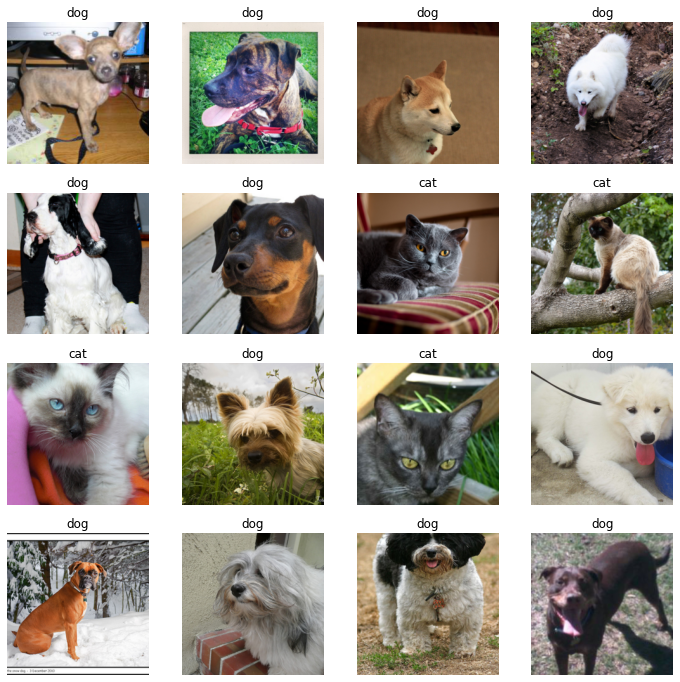

In [11]:
dls.show_batch(max_n=16)

In [12]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\Moon/.cache\torch\hub\checkpoints\resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

- 만약 에러가 난다면 아래 코드를 실행한 뒤 커널을 재시작한다.

In [13]:
# !conda install -c conda-forge jupyterlab_widgets -y
# !conda install -c conda-forge ipywidgets -y
# !conda install -c conda-forge nodejs -y

In [16]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: 